# Solar Sizing Optimization code 

+ 1 ha
+ Direct-drive system

In [1]:

#Imports 
import pvlib
from pvlib.location import Location
from pvlib import pvsystem, location, modelchain, iotools
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pathlib
from datetime import datetime
from dataclasses import dataclass
import sqlite3
import scipy

In [2]:
#Worst day from PlantWaterCalcs.ipynb
Q_max = 20.7504 #m3/day for 1ha
day_max = pd.to_datetime('2020-06-11').date()
max_flow_rate = (2*50*34) /(1000*3600) #m3/s
time_min = (Q_max) / (max_flow_rate* 3600) #hours


#Pump P vs Q equation from PumpCurve.ipynb --> P = a*Q^3 + b*Q^2 + c*Q + c
a = 445687894.591783
b = -984696.5871017637
c = 854.0710206707552
d = -0.05692714507987253

max_power = a*(max_flow_rate**3) + b*(max_flow_rate**2) + c*max_flow_rate + d #kw



In [48]:
max_flow_rate

0.0009444444444444445

In [3]:
def root_pump_curve(a,b,c,d,P,Q):
    '''function Return zero in terms of Q of pump power equation given a,b,c,d and P'''
    return (a*(Q**3) + b*(Q**2) + c*Q + d - P)

## Worst day sizing

In [4]:
#Import and clean Solar data 
con = sqlite3.connect("../NetworkCode/SolarData.sqlite")
df_weather_CEBIVE_raw = pd.read_sql_query("SELECT * from cebiveSolarDailyHourly", con)
con.close()

#Convert date to datetime
df_weather_CEBIVE_raw['iso_date'] = pd.to_datetime(df_weather_CEBIVE_raw['iso_date'])
df_weather_CEBIVE_raw.index = pd.to_datetime(df_weather_CEBIVE_raw['iso_date'])

#Only data where location is CEBIVE and date is day_max
df_weather = df_weather_CEBIVE_raw[(df_weather_CEBIVE_raw['location'] == 'CEBIVE') & (df_weather_CEBIVE_raw['iso_date'].dt.date == day_max)]

#Formatting data to input into pvlib model
weather = pd.DataFrame({
    'ghi': df_weather['Cloudy_sky.ghi'], 'dhi': df_weather['Cloudy_sky.dhi'], 'dni': df_weather['Cloudy_sky.dni'],
    'temp_air':  df_weather['Temp'], 'wind_speed':  df_weather['wind_speed'], 
})

loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE

In [5]:
#Configure solar model
solpos = loc.get_solarposition(weather.index)

#Default --> change to correct pannels values 
module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']



1 panels is NOT enough
2 panels is enough for 6.103058823529412 hours of power for the worst day with 0.25 kW of max power


Text(0, 0.5, 'AC Power [kW]')

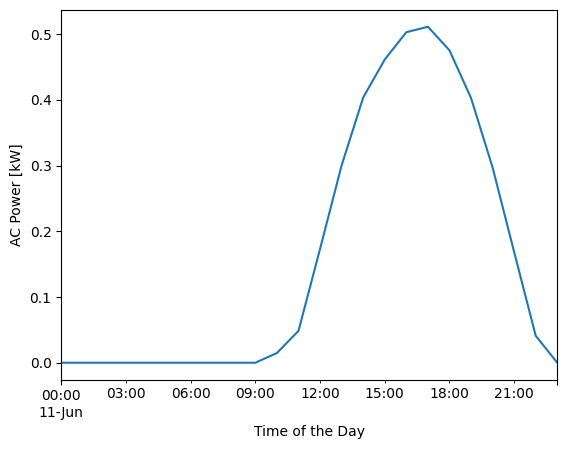

In [6]:
#Is one pannel enough for the worst day? 

flag = 0 # 0 = infufficient power production for worst day
n_panels = 1 #intial number of PV panels

while flag == 0: 

    #Calculate solar panel power production for worst day with n panels
    array = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels)
    system = pvsystem.PVSystem(arrays=[array], inverter_parameters={'pdc0': 1, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc2 = modelchain.ModelChain(system, loc, spectral_model='no_loss')
    _ = mc2.run_model(weather)
    
    #Check if enough power is produced for worst day
    n_hours = 0 # hours with power greater than or equal to max_power
    for i in range(len(mc2.results.ac)):
        if mc2.results.ac.iloc[i] >= max_power:
            n_hours += 1

    if n_hours >= time_min:
        flag = 1
        print(f"{n_panels} panels is enough for {time_min} hours of power for the worst day with {max_power:.2f} kW of max power")
        break
    else:
        print(f'{n_panels} panels is NOT enough') 
        n_panels += 1

    if n_panels > 10: #safty check
        print(f"Could not find enough panels with 10 panels")
        
mc2.results.ac.plot()
plt.xlabel('Time of the Day')
plt.ylabel('AC Power [kW]')

## Sizing for entire historical dataset

In [7]:
#How about for the entire historical data set? 

df_daily_irrigation =  pd.read_pickle('../NetworkCode/df_areas.pkl') #daily irrigation need in m3/day for 1h, 2ha and 3ha 
df_daily_irrigation['1ha_hrs'] = df_daily_irrigation['1 ha'] / (max_flow_rate* 3600) # convert to hrs
df_daily_irrigation['2ha_hrs'] = df_daily_irrigation['2 ha'] / (max_flow_rate* 3600) 
df_daily_irrigation['3ha_hrs'] = df_daily_irrigation['3 ha'] / (max_flow_rate* 3600) 
df_daily_irrigation.index = pd.to_datetime(df_daily_irrigation.index)


#create full weather data set
df_weather_full = df_weather_CEBIVE_raw[(df_weather_CEBIVE_raw['location'] == 'CEBIVE')]
df_weather_full.index = pd.to_datetime(df_weather_full['iso_date'])
weather_full = pd.DataFrame({
    'ghi': df_weather_full['Cloudy_sky.ghi'], 'dhi': df_weather_full['Cloudy_sky.dhi'], 'dni': df_weather_full['Cloudy_sky.dni'],
    'temp_air':  df_weather_full['Temp'], 'wind_speed':  df_weather_full['wind_speed'], 
})

#run PVlib model for full year
loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
solpos = loc.get_solarposition(weather_full.index)
module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels)
system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 1, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
_ = mc_full.run_model(weather_full)

df_solar_full = pd.DataFrame({'solar_power': mc_full.results.ac})


#see if enough power is available each day for 1ha
weather_full_index = pd.to_datetime(weather_full.index.date).unique()

for day in weather_full_index.date:
    print(day)
    daily_power = df_solar_full.loc[df_solar_full.index.date == day]
   
    n_hrs = 0 # hours with power greater than or equal to max_power
    for i in range(len(daily_power)):
        if daily_power['solar_power'].iloc[i] >= max_power:
            n_hrs += 1  
    
    day_timestamp = pd.Timestamp(day)
    if day_timestamp in df_daily_irrigation.index:
        day_loc = df_daily_irrigation.index.get_loc(day_timestamp)  

        if n_hrs >= df_daily_irrigation['1ha_hrs'].iloc[day_loc]:
            print(f"{day} has enough power for 1ha")
        else:
            print(f"{day} does not have enough power for 1ha, {df_daily_irrigation['1ha_hrs'].iloc[day_loc] - n_hrs} hours short")

            break 
    else: 
         print(f"{day} is not found in df_daily_irrigation index")


##Fails on 2010-01-03 --> how to take into acount variable speed when power is less than max power



2010-01-01
2010-01-01 has enough power for 1ha
2010-01-02
2010-01-02 has enough power for 1ha
2010-01-03
2010-01-03 does not have enough power for 1ha, 0.9178823529411766 hours short


In [8]:
#accouting for variable speed operation

#Calculate the flow rate [m3/s] for each hour for variable speed pump 
df_solar_full['flow_rate'] = 0 #initialize column
# Iterate over the index of df_solar_full directly
for hour in df_solar_full.index:
    if df_solar_full.loc[hour, 'solar_power'] >= max_power:
        df_solar_full.loc[hour, 'flow_rate'] = max_flow_rate
    elif df_solar_full.loc[hour, 'solar_power'] == 0:
        # Handle the case when solar power is zero 
        df_solar_full.loc[hour, 'flow_rate'] = 0
    else:
        # Use root_scalar to find the root of the pump curve equation
        solution = scipy.optimize.root_scalar(lambda x: root_pump_curve(a, b, c, d, df_solar_full.loc[hour, 'solar_power'], x), x0=max_flow_rate)
        df_solar_full.loc[hour, 'flow_rate'] = solution.root

# Check for negative flow rates
negative_flow_rates = df_solar_full[df_solar_full['flow_rate'] < 0]
if not negative_flow_rates.empty:
    raise ValueError(f"Negative flow rates found in hours: {negative_flow_rates.index.tolist()}")


# Assuming constant flow rate over each hour, calculate the total daily pumpible water 
df_solar_full['flow_rate_hourly']= df_solar_full['flow_rate'] * 3600
df_daily_irrigation['1ha variable speed'] =  df_solar_full['flow_rate_hourly'].resample('D').sum()

#Is the possible irrigaiation with variable speed operation sufficient? 

for day in df_daily_irrigation.index:
    if df_daily_irrigation['1 ha'].loc[day] > df_daily_irrigation['1ha variable speed'].loc[day]:
        print(f'{n_panels} is not sufficient even with variable speed operation, on {day} the power deficit is {df_daily_irrigation["1 ha"].loc[day] - df_daily_irrigation["1ha variable speed"].loc[day]} m3')
        break   

#Even with variable speed operation, the number of panels is insufficient --> Increase number of panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_2025/1607703907.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.518980613802592e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 is not sufficient even with variable speed operation, on 2010-03-05 00:00:00 the power deficit is 3.382076861221691 m3


In [9]:
## Increase number of panels until sufficient amount to cover all historical days with variable speed operation

flag = 0 # flag == 0 --> insufficient number of panels, flag == 1 --> sufficient number of panels found 
n_panels = 1 # number of panels to use

while flag == 0: 

    #Calculate solar panel power production for all days with n panels
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 5, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)

    df_solar_full = pd.DataFrame({'solar_power': mc_full.results.ac})

    #Calculate the flow rate [m3/s] for each hour for variable speed pump 
    df_solar_full['flow_rate'] = 0 #initialize column
    # Iterate over the index of df_solar_full directly
    for hour in df_solar_full.index:
        if df_solar_full.loc[hour, 'solar_power'] >= max_power:
            df_solar_full.loc[hour, 'flow_rate'] = max_flow_rate
        elif df_solar_full.loc[hour, 'solar_power'] == 0:
            #Handle the case when solar power is zero 
            df_solar_full.loc[hour, 'flow_rate'] = 0
        else:
            # Use root_scalar to find the root of the pump curve equation
            solution = scipy.optimize.root_scalar(lambda x: root_pump_curve(a, b, c, d, df_solar_full.loc[hour, 'solar_power'], x), x0=max_flow_rate)
            df_solar_full.loc[hour, 'flow_rate'] = solution.root

    # SAFETY: Check for negative flow rates
    negative_flow_rates = df_solar_full[df_solar_full['flow_rate'] < 0]
    if not negative_flow_rates.empty:
        raise ValueError(f"Negative flow rates found in hours: {negative_flow_rates.index.tolist()}")


    # Assuming constant flow rate over each hour, calculate the total daily pumpible water 
    df_solar_full['flow_rate_hourly']= df_solar_full['flow_rate'] * 3600
    df_daily_irrigation['1ha variable speed'] =  df_solar_full['flow_rate_hourly'].resample('D').sum()

    #Is the possible irrigaiation with variable speed operation sufficient  with n_panels? 
    day_flag = 0 # flag == 0 --> insufficient number of panels, flag == 1 --> sufficient number of panels found
    for day in df_daily_irrigation.index:
        if df_daily_irrigation['1 ha'].loc[day] > df_daily_irrigation['1ha variable speed'].loc[day]:
            print(f'{n_panels} panel(s) is not sufficient with variable speed operation, on {day} the irrigation deficit is {df_daily_irrigation["1 ha"].loc[day] - df_daily_irrigation["1ha variable speed"].loc[day]} m3')
            day_flag = 1
        
    if day_flag == 1:
        n_panels += 1
    else:
        flag = 1
        print(f'{n_panels} panel(s) is sufficient with variable speed operation')

    if n_panels > 10: #safety check
        raise ValueError('the number of PV panels required is greater than 10')         


#Takes a bit over 4 mins to run

/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_2025/1477626477.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00015324026076758454' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


1 panel(s) is not sufficient with variable speed operation, on 2010-01-03 00:00:00 the power deficit is 3.1866219304277434 m3
1 panel(s) is not sufficient with variable speed operation, on 2010-01-08 00:00:00 the power deficit is 3.9334477363572073 m3
1 panel(s) is not sufficient with variable speed operation, on 2010-01-11 00:00:00 the power deficit is 2.5510646280423037 m3
1 panel(s) is not sufficient with variable speed operation, on 2010-01-15 00:00:00 the power deficit is 2.9181522051643727 m3
1 panel(s) is not sufficient with variable speed operation, on 2010-01-25 00:00:00 the power deficit is 4.644740867239737 m3
1 panel(s) is not sufficient with variable speed operation, on 2010-01-26 00:00:00 the power deficit is 5.392756314858911 m3
1 panel(s) is not sufficient with variable speed operation, on 2010-02-01 00:00:00 the power deficit is 0.18119905156922123 m3
1 panel(s) is not sufficient with variable speed operation, on 2010-02-18 00:00:00 the power deficit is 0.7791313128760

/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_2025/1477626477.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0003305698615150383' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 panel(s) is not sufficient with variable speed operation, on 2010-03-05 00:00:00 the power deficit is 5.943186477957459 m3
2 panel(s) is not sufficient with variable speed operation, on 2010-03-06 00:00:00 the power deficit is 5.001332776443114 m3
2 panel(s) is not sufficient with variable speed operation, on 2017-04-24 00:00:00 the power deficit is 1.5046179637951402 m3
2 panel(s) is not sufficient with variable speed operation, on 2018-07-10 00:00:00 the power deficit is 1.7243441210476096 m3
2 panel(s) is not sufficient with variable speed operation, on 2022-04-17 00:00:00 the power deficit is 0.8358977306492168 m3
2 panel(s) is not sufficient with variable speed operation, on 2022-10-25 00:00:00 the power deficit is 3.236818292324241 m3
2 panel(s) is not sufficient with variable speed operation, on 2023-07-25 00:00:00 the power deficit is 3.017825608490547 m3
2 panel(s) is not sufficient with variable speed operation, on 2023-08-12 00:00:00 the power deficit is 0.1199728888754627

/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_2025/1477626477.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7.728291653734108e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


3 panel(s) is not sufficient with variable speed operation, on 2010-03-05 00:00:00 the power deficit is 4.101254089184871 m3
3 panel(s) is not sufficient with variable speed operation, on 2010-03-06 00:00:00 the power deficit is 2.133909079389608 m3


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_2025/1477626477.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.283185102327231e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


4 panel(s) is not sufficient with variable speed operation, on 2010-03-05 00:00:00 the power deficit is 0.7560350857236919 m3


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_2025/1477626477.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00010901409975746773' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


5 panel(s) is sufficient with variable speed operation


## Battery system sizing optimization 

+ 1ha


In [10]:
# Assumed battery characterisitics #### TODO: add real battery characteristics

eta_charge = 0.95
eta_discharge = 0.95
SOC_min = 0.2 #20%
SOC_initial = 0.8 #80%
SOC_max = 0.8 #80%
deprciation = 0.01 # 1% per day
capacity = 1 #kWh

In [37]:
#sizing number of panels if energy can be stored over time with battery

n_panels_battery = 1 #number of panels
flag = 0 #flag == 0 --> insufficient number of panels, flag == 1 --> sufficient number of panels found

while flag == 0: 
    #solar power production for historical data with n_panels_battery 
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels_battery)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 5, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)
    df_solar_battery = pd.DataFrame({'solar_power': mc_full.results.ac})

    E_stored = [0] #kWh, battery energy stored over time
    day_flag = 0 
    #seeing if enough power is available each day given n_panels_battery
    for day, data in df_solar_battery.groupby(df_solar_battery.index.date):
        Q_day = 0 # m3 of water irrigated on day 
        Q_needed = df_daily_irrigation['1 ha'].loc[day.strftime('%Y-%m-%d')] #required irrigation in m3 
        power_day = df_solar_battery['solar_power'].loc[day.strftime('%Y-%m-%d')]
        
        for hour in data.index.hour:
            deficit = Q_needed - Q_day
            power = power_day.iloc[hour] #Power available to pump on that hour

            if deficit > 0: #Need to irrigate more water

                if (power >= max_power) & (deficit > max_flow_rate * 3600): #Power is greater than max power so irrigate max possinle amount 
                    Q_day += max_flow_rate * 3600
                    E_stored.append(E_stored[-1] + (power-max_power) * eta_charge) #kWh

                elif (power >= max_power) & (deficit <= max_flow_rate * 3600): #power is greater than max power but dont need to pump max amount
                   P_used = a * (deficit/3600)**3 + b * (deficit/3600)**2 + c * (deficit/3600) + d #power used to pump
                   Q_day += deficit
                   E_stored.append(E_stored[-1] + (power-P_used) * eta_charge) #kWh

                elif (power == 0): 
                    #no energy stored
                    Q_day += 0
                else: #power is less than max power, but still need to pump 
                    Q_possible = scipy.optimize.root_scalar(lambda x: root_pump_curve(a, b, c, d, power, x), x0=max_flow_rate)
                    Q_day += Q_possible.root * 3600
                    #no energy stored

            else: #dont need to irrigate more
                E_stored.append(E_stored[-1]+power*eta_charge) #all  energy is stored in battery 

        if deficit > 0: #still need to irrigate more after all possible pumping hours have been exhausted
            #Use energy stored to pump --> Assume always pumping at max flow rate
            time_pump = (deficit / 3600)/ max_flow_rate 
            E_pump = max_power * time_pump / eta_discharge

            if E_stored[-1] > E_pump: #if enough energy is stored to pump
                E_stored.append(E_stored[-1] - E_pump)
            else: #if not enough energy is stored to pump
                print(f'{n_panels_battery} panels is not sufficient with battery operation, on {day} the energy deficit is {E_pump - E_stored[-1]} kWh')
                day_flag = 1 #flag == 1 --> n_panels_battery is not sufficient with battery operation over historical data
            
    if day_flag == 1: #after checking all days, if n_panels_battery is not sufficient with battery operation
        n_panels_battery+=1   
    else: #after checking all days, n_panels_battery is sufficient with battery operation  
        flag = 1 
        print(f'{n_panels_battery} panels is sufficient with battery operation over historical data')

    if n_panels_battery > 10: #safety check
        raise ValueError('the number of PV panels required is greater than 10')
    
## BUT, this assumes the storage is empty at the beginning of the year, the next cell amounts for the fact that is full 

1 panels is not sufficient with battery operation, on 2010-01-03 the energy deficit is 0.029241209860041195 kWh
2 panels is sufficient with battery operation over historical data


In [43]:
# Find minimum number of batteries required to cover all historical days 1 through 5 PV pannels 

for n_panels_battery in range(1, 6): #number of panels
    n_batteries = 0 #number of batteries in the string 
    flag = 0 #flag == 0 --> insufficient battery capacity found, flag == 1 --> sufficient battery capacity found

    #Calculate solar power output with n_pannels_battery
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels_battery)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 5, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)
    df_solar_battery = pd.DataFrame({'solar_power': mc_full.results.ac})
    

    #find minimum number of batteries needed to cover all historical days 
    while flag == 0:
        battery_capacity = capacity * n_batteries #kWh
        min_SOC = SOC_min * battery_capacity
        max_SOC = SOC_max * battery_capacity
        E_stored = [battery_capacity] #kWh, battery energy stored over time, initially full 
        day_flag = 0 
        for day, data in df_solar_battery.groupby(df_solar_battery.index.date):
            Q_day = 0 # m3 of water irrigated on day 
            Q_needed = df_daily_irrigation['1 ha'].loc[day.strftime('%Y-%m-%d')] #required irrigation in m3 
            power_day = df_solar_battery['solar_power'].loc[day.strftime('%Y-%m-%d')]
            
            for hour in data.index.hour:
                deficit = Q_needed - Q_day
                power = power_day.iloc[hour] #Power available to pump on that hour

                if deficit > 0: #Need to irrigate more water
                    if (power >= max_power) & (deficit > max_flow_rate * 3600): #Power is greater than max power so irrigate max possinle amount 
                        Q_day += max_flow_rate * 3600
                        E_storable = (power- max_power) * eta_charge #kWh
                    elif (power >= max_power) & (deficit <= max_flow_rate * 3600): #power is greater than max power but dont need to pump max amount
                        P_used = a * (deficit/3600)**3 + b * (deficit/3600)**2 + c * (deficit/3600) + d #power used to pump
                        Q_day += deficit
                        E_storable = (power- P_used) * eta_charge #kWh    
                    elif (power == 0): 
                        E_storable = 0 #no energy stored
                        Q_day += 0
                    elif (power < max_power): #power is less than max power, but still need to pump 
                        Q_possible = scipy.optimize.root_scalar(lambda x: root_pump_curve(a, b, c, d, power, x), x0=max_flow_rate)
                        E_storable = 0 #no energy stored
                        if Q_possible.root*3600 >= deficit:
                            Q_day += deficit
                        else:
                            Q_day += Q_possible.root * 3600
                    

                else: #dont need to irrigate more
                    E_storable =power*eta_charge 

                #Store energy
                if (E_storable + E_stored[-1]*(1-deprciation)) <= max_SOC:
                    E_stored.append(E_stored[-1]*(1-deprciation) + E_storable) #kWh
                else: #if more energy than battery can store, only store what battery can store
                    E_stored.append(max_SOC) #kWh
                
            
                
            if deficit > 0: #still need to irrigate more after all possible pumping hours have been exhausted
                
                #Use energy stored to pump --> Assume always pumping at max flow rate
                time_pump = (deficit / 3600)/ max_flow_rate 
                E_pump = (max_power * time_pump) / eta_discharge

                
                if (E_stored[-1] - E_pump) >= min_SOC: #if enough energy is stored to pump
                    E_stored.append(E_stored[-1]*(1-deprciation) - E_pump)
                else: #if not enough energy is stored to pump
                    #print(f'{n_batteries} batteries is not sufficient with {n_panels_battery} panels, on {day} the energy deficit is {E_pump - (E_stored[-1]- min_SOC)} kWh')
                    day_flag = 1 #flag == 1 --> n_panels_battery is not sufficient with battery operation over historical data

        if day_flag == 1: #after checking all days, if n_batteries is not sufficient with n_panels_battery
            n_batteries+=1
        else: #after checking all days, n_batteries is sufficient with n_panels_battery
            flag = 1 
            print(f'{n_batteries} batteries is sufficient with {n_panels_battery} panels over historical data')
                
                    
        if n_batteries > 20: #safety check
            print(f'the required number of batteries is more than 20 for {n_panels_battery} panels')
            flag = 1
            
        
    #Takes 7m 55 with max 10 batteries
    #Takes 13m 4 with max 20 batteries


the required number of batteries is more than 10 for 1 panels
3 batteries is sufficient with 2 panels over historical data
2 batteries is sufficient with 3 panels over historical data
1 batteries is sufficient with 4 panels over historical data
0 batteries is sufficient with 5 panels over historical data


## Solar sizing with Tank configuration 
+ 1 ha 

In [ ]:
#TODO 1. find needed height of tank to create sufficieent pressure/flow rate
#       2. Define min SOC of tank (to create sufficient flow rate)
#       3. figure out evaporation/loss rate
#       4. Assuming always max flow rate as output of tank, 

In [99]:
#Determinig needed height of tank to create sufficient pressure/flow rate

def system_curve (Q): 
    "based on a given flow rate (Q) in L/min return the Head (m) of the 1ha system with values for polyfit (DripNetwork.ipynb)"
    return 0.004718754073931565 * (Q**2) + 0.04734825179183301 * Q 

def total_system_curve (Q):
    "based on a given flow rate (Q) L/mim return the Head (m) including static head of the 3ha system with values for polyfit (DripNetwork.ipynb)"
    return system_curve(Q) + 60.78973049433738

max_system_head = system_curve(max_flow_rate * 60 * 1000)
print(f" the maximum head of the system is {max_system_head}m so the tank height is {max_system_head} m")



 the maximum head of the system is 17.835511238939677m so the tank height is 17.835511238939677 m


In [98]:
def tank_pump_curve (Q):
    """based on a given flow rate (Q) in m3/s return the electrical Power (kW) of the pump for the tank configuration (H = 80.8) with variable speed op
        from PumpCurve.ipynb"""
    return 152054186.35597843*Q**3 + -172700.38396421436*Q**2 + 357.18109285749836*Q + -0.005691445084420055

tank_max_flow_rate = 0.003072606294153521 #m3/s
tank_max_power = tank_pump_curve(tank_max_fow_rate) 

def tank_system_curve_root(P, Q):
    return 152054186.35597843 * Q**3 - 172700.38396421436 * Q**2 + 357.18109285749836 * Q - 0.005691445084420055 - P



#### 20 meters typically maximum so can only work for 1 ha farm for plantains 

In [57]:
#calculate the pump curve (Q) for H_static + H_pump = H_tank at different powers
# H_pump = = 80 .8 m 
#the equation of the pump curve is 445687894.59178245Q^3 + -984696.5871017603Q^2 + 854.0710206707518Q + -0.05692714507987217 for a constant H_static of 80.8m

#sizing number of panels if energy can be stored over time with tank

n_panels_tank = 1 #number of panels
flag = 0 #flag == 0 --> insufficient number of panels, flag == 1 --> sufficient number of panels found
hrly_max_out = max_flow_rate * 3600

while flag == 0: 
    #solar power production for historical data with n_panels_tank 
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels_battery)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 5, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)
    df_solar_battery = pd.DataFrame({'solar_power': mc_full.results.ac})

    Q_stored = [0] #m3, water stored over time
    day_flag = 0 
    
    for day, data in df_solar_battery.groupby(df_solar_battery.index.date):
        Q_day_irrigated = 0 # m3 of water irrigated on day 
        Q_needed = df_daily_irrigation['1 ha'].loc[day.strftime('%Y-%m-%d')] #required irrigation in m3 
        power_day = df_solar_battery['solar_power'].loc[day.strftime('%Y-%m-%d')]
        
        for hour in data.index.hour:
            power = power_day.iloc[hour] #Power available to pump on that hour
            
            #possible input into the tank
            if power > tank_max_power:
                Q_possible_stored = tank_max_fow_rate * 3600
            elif power == 0:
                Q_possible_stored = 0
            elif power < tank_max_power:
                sol = scipy.optimize.root_scalar(lambda x: tank_system_curve_root(power,x), x0=tank_max_fow_rate)
                Q_possible_stored = sol.root * 3600
            
            Q_stored.append(Q_stored[-1] + Q_possible_stored) #stored water of that hour 

            #output from the tank
            deficit = Q_needed - Q_day_irrigated #m3
            
            if (deficit >= hrly_max_out) & (Q_stored[-1] >= hrly_max_out):
                Q_day_irrigated += hrly_max_out 
                Q_stored.append(Q_stored[-1] - hrly_max_out)

            
            elif (deficit >= hrly_max_out) & (Q_stored[-1] < hrly_max_out):
                Q_day_irrigated += Q_stored[-1]
                Q_stored.append(0)
                
            elif (deficit == 0) :
                Q_day_irrigated += 0 
                Q_stored.append(Q_stored[-1])
            
            elif ( 0 < deficit < hrly_max_out) & (Q_stored[-1] >= deficit):
                Q_day_irrigated += deficit
                Q_stored.append(Q_stored[-1] - deficit)
            
            elif ( 0 < deficit < hrly_max_out) & (Q_stored[-1] < deficit):
                Q_day_irrigated += Q_stored[-1]
                Q_stored.append(0)

            
            if Q_stored[-1] < 0:
                raise ValueError('Q_stored is negative')

        if Q_day_irrigated < Q_needed:
            day_flag == 1 
            print(f'on {day}, {n_panels_tank} panels is not sufficient with a tank, the irrigation deficit is {Q_needed - Q_day_irrigated} m3')
            
    if day_flag == 1:
        n_panels_tank += 1
    else:
        flag = 1
        print(f'{n_panels_tank} panel(s) is sufficient with tank operation')



                
            
#1 panel is sufficient with tank operation, but what is the minimum tank size? 


1 panel(s) is sufficient with tank operation


In [117]:
hlry_max_out = max_flow_rate * 3600 #m3/hr

for n_panels_tank in range(1, 6):
    Q_tank_capacity = 0 #Intial tank capacity in m3 
    flag = 0  #flag == 0 --> insufficient tank capacity , flag == 1 --> sufficient tank capacity found
    
    #solar production 
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels_tank)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 5, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)
    df_solar_tank = pd.DataFrame({'solar_power': mc_full.results.ac})

    while flag == 0:
        day_flag = 0 #flag == 0 --> insufficient tank capacity , flag == 1 --> sufficient tank capacity found
        Q_stored = [Q_tank_capacity] # assume tank is full to start with
        

        for day in df_daily_irrigation.index:
            Q_day_irrigated = 0 # m3
            Q_needed = df_daily_irrigation['1 ha'].loc[day.strftime('%Y-%m-%d')] #required irrigation in m3 
            power_day = df_solar_tank['solar_power'].loc[day.strftime('%Y-%m-%d')]
            
            for hour in data.index.hour:
                power = power_day.iloc[hour] #Power available to pump on that hour
                deficit = Q_needed - Q_day_irrigated

                if power >= tank_max_power:
                    Q_in = tank_max_flow_rate * 3600  #m3/hr
                elif (0 < power < tank_max_power):
                    sol = scipy.optimize.root_scalar(lambda x: tank_system_curve_root(power,x), x0=tank_max_flow_rate)
                    Q_in = sol.root * 3600
                elif power == 0:
                    Q_in = 0 #no water can be entered 

                if deficit >= hlry_max_out: #Need to irrigate more than max output
                    if Q_in > hrly_max_out:
                        Q_day_irrigated += hrly_max_out
                        Q_net = Q_in - hrly_max_out
                    else:
                        if Q_stored[-1] >= hrly_max_out - Q_in:
                            Q_day_irrigated += hrly_max_out
                            Q_net = Q_in - (hrly_max_out - Q_in)
                        else: 
                            Q_day_irrigated += Q_in + Q_stored[-1] 
                            Q_net = - Q_stored[-1]

                elif (0 < deficit < hlry_max_out):
                    if Q_in > deficit:
                        Q_day_irrigated += deficit
                        Q_net = Q_in - deficit
                    else:
                        if Q_stored[-1] >= deficit - Q_in:
                            Q_day_irrigated += deficit
                            Q_net = Q_in - (deficit - Q_in)
                        else:
                            Q_day_irrigated += Q_in + Q_stored[-1]
                            Q_net = - Q_stored[-1]
                else: #deficit == 0 
                    Q_day_irrigated += 0
                    Q_net = Q_in

                if Q_stored[-1] + Q_net > Q_tank_capacity:
                    Q_stored.append(Q_tank_capacity)
                else:
                    Q_stored.append(Q_stored[-1] + Q_net)

                if Q_stored[-1] < 0: #safety check
                    raise ValueError('Q_stored is negative')
            
            #print(f'{Q_day_irrigated}m3 was irrigated and {Q_needed}m3 was needed on {day}')
            if Q_day_irrigated < Q_needed:
                day_flag = 1 
                #print(f'on {day}, {n_panels_tank} panels is not sufficient with a tank, the irrigation deficit is {Q_needed - Q_day_irrigated} m3')

        if day_flag == 0:
            flag = 1
            print(f'{Q_tank_capacity} m3 of tank capacity is sufficient with {n_panels_tank} panel(s)')
        else: 
            print(f'{Q_tank_capacity}m3 of tank capcitoy is NOT sufficient for {n_panels_tank} panel(s)')
            Q_tank_capacity += 1 #m3

        if Q_tank_capacity > 20: #safety check
            print(f'the required tank capacity with {n_panels_tank} panel(s) is more than 20 m3')
            flag = 1

  
            

0m3 of tank capcitoy is NOT sufficient for 1 panel(s)
1m3 of tank capcitoy is NOT sufficient for 1 panel(s)
2m3 of tank capcitoy is NOT sufficient for 1 panel(s)
3m3 of tank capcitoy is NOT sufficient for 1 panel(s)
4m3 of tank capcitoy is NOT sufficient for 1 panel(s)
5m3 of tank capcitoy is NOT sufficient for 1 panel(s)
6m3 of tank capcitoy is NOT sufficient for 1 panel(s)
7m3 of tank capcitoy is NOT sufficient for 1 panel(s)
8m3 of tank capcitoy is NOT sufficient for 1 panel(s)
9m3 of tank capcitoy is NOT sufficient for 1 panel(s)
10m3 of tank capcitoy is NOT sufficient for 1 panel(s)
11m3 of tank capcitoy is NOT sufficient for 1 panel(s)
12m3 of tank capcitoy is NOT sufficient for 1 panel(s)
13m3 of tank capcitoy is NOT sufficient for 1 panel(s)
14m3 of tank capcitoy is NOT sufficient for 1 panel(s)
15m3 of tank capcitoy is NOT sufficient for 1 panel(s)
16m3 of tank capcitoy is NOT sufficient for 1 panel(s)
17m3 of tank capcitoy is NOT sufficient for 1 panel(s)
18m3 of tank capcito

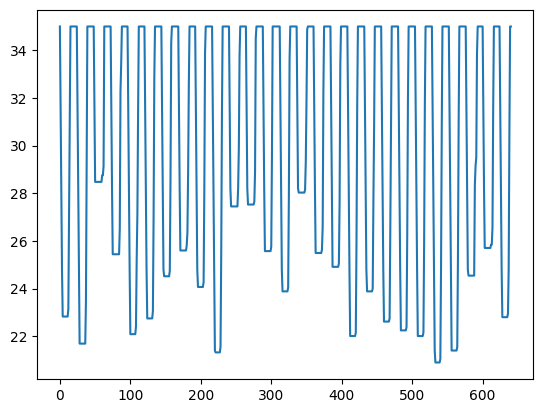

In [109]:
plt.plot(Q_stored)

In [110]:
df_daily_irrigation['1 ha']

date
2010-01-01    12.1704
2010-01-02    13.3056
2010-01-03     6.5208
2010-01-04     9.5568
2010-01-05    12.9096
               ...   
2023-12-27     8.9232
2023-12-28     7.3656
2023-12-29     6.8112
2023-12-30     7.9464
2023-12-31     5.1480
Name: 1 ha, Length: 5113, dtype: float64